# KE5105 - Building Electrical Consumption Forecasting

# Modelling 11 - Fine-tune model

## Summary of Findings
* Use imputed building dataset
* Improve the data normalisation (fit_transform on training split; transform on validation split)
* Mini-batch data generation
	* No shuffling of mini-batch number (i.e. the order of the mini-batches is chronological)
	* No shuffling of samples within a mini-batch
	* Min Validation MAE (normalised) = 2.393 (0.0329) @ epoch 98
* Stateful GRU
	* Min Validation MAE (normalised) = 2.061 (0.0300) @ epoch 109

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython',
 '/home/tkokkeng/Documents/KE5105/ETL/source']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline

from keras import layers
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from keras.regularizers import l1,l2, l1_l2
from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


## Load data for building AS5

In [4]:
as5_train = mu.load_data_by_bldg(['AS5'], 'imputed_train')

In [5]:
as5_train[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     30027 non-null float64
B

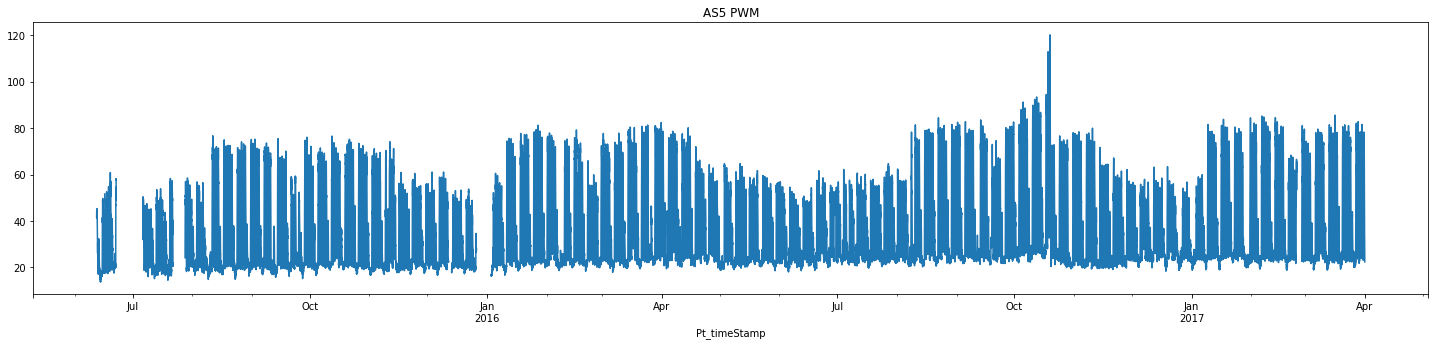

In [6]:
as5_train_df = as5_train[0][1]
as5_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='AS5 PWM')

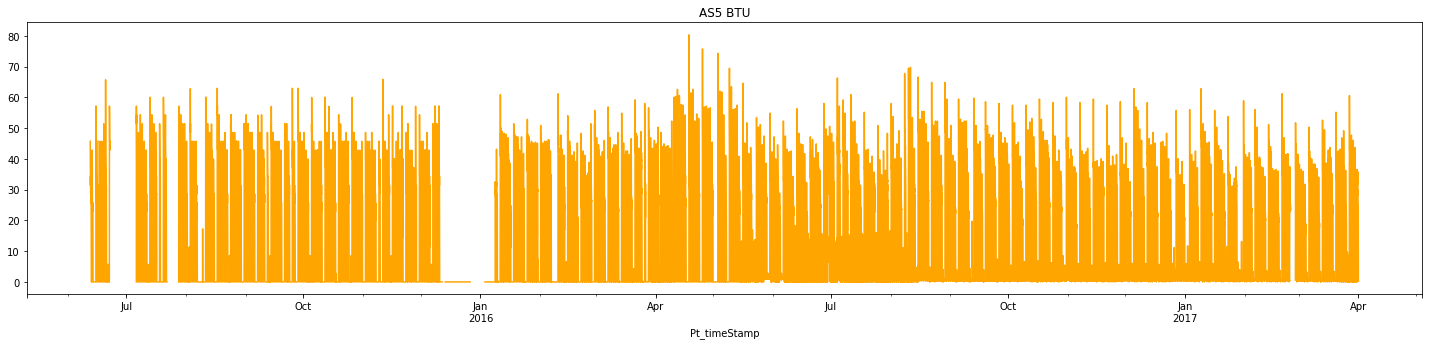

In [7]:
as5_train_df['BTU_30min_avg'].plot(figsize=(25, 5), title='AS5 BTU', color='orange')

## Split a validation set out from the train set

In [8]:
as5_train_split_df = as5_train_df[:20000]
as5_val_split_df = as5_train_df[20000:]

In [9]:
print('train split = %s\nvalidation split = %s' % (as5_train_split_df.shape, as5_val_split_df.shape))

train split = (20000, 17)
validation split = (11616, 17)


## Transform the training data
* Normalise the data - convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [10]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    # ('yeo-johnson_transform', PowerTransformer(method='yeo-johnson', standardize=False, copy=True)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [11]:
as5_train_data = my_pipeline.fit_transform(as5_train_split_df)
as5_train_data

array([[0.40696488, 0.56924225],
       [0.41425033, 0.53427896],
       [0.43450386, 0.53353241],
       ...,
       [0.15255719, 0.02140102],
       [0.16873088, 0.0390693 ],
       [0.15503424, 0.00348389]])

In [12]:
as5_train_data.shape

(20000, 2)

Text(0.5, 1.0, 'Normalised PWM Training Data')

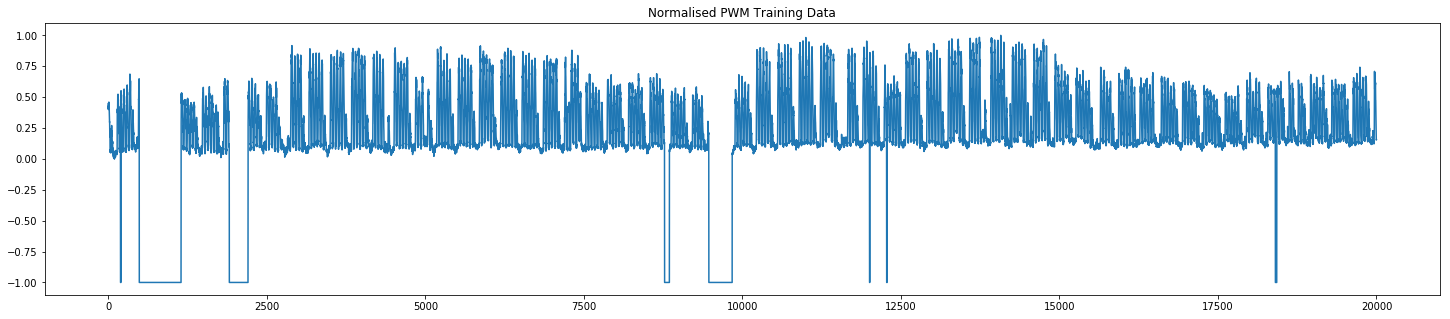

In [13]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

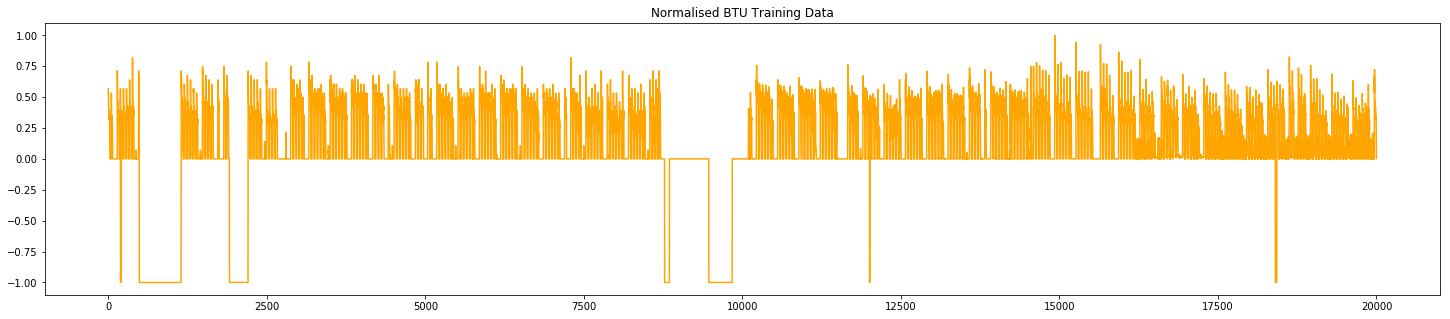

In [14]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

In [15]:
as5_val_data = my_pipeline.transform(as5_val_split_df)
as5_val_data

array([[1.52120064e-01, 2.15842164e-20],
       [1.56199913e-01, 2.15842164e-20],
       [1.60716888e-01, 1.99328108e-01],
       ...,
       [1.99912575e-01, 3.22259550e-02],
       [1.59842634e-01, 3.48388702e-03],
       [1.25570108e-01, 3.46599347e-03]])

In [16]:
as5_val_data.shape

(11616, 2)

Text(0.5, 1.0, 'Normalised PWM Validation Data')

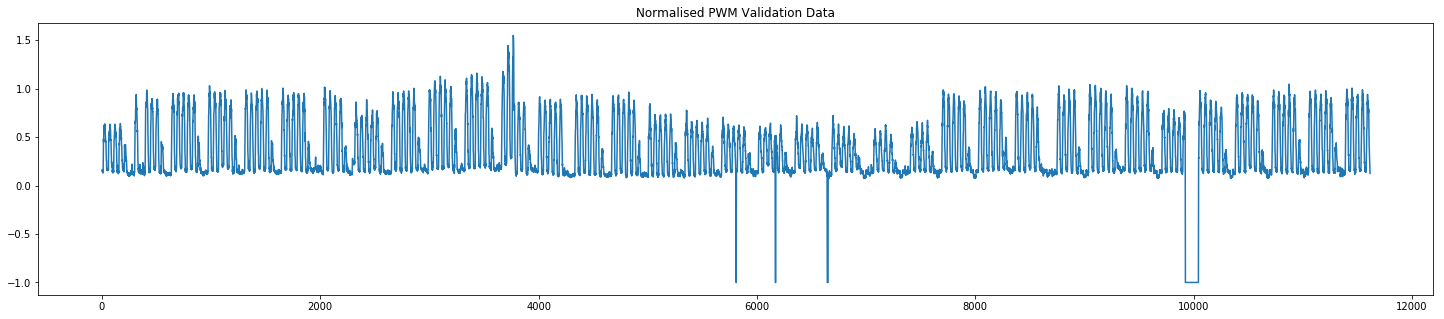

In [17]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_val_data.shape[0]), as5_val_data[:, 0])
plt.title('Normalised PWM Validation Data')

Text(0.5, 1.0, 'Normalised BTU Validation Data')

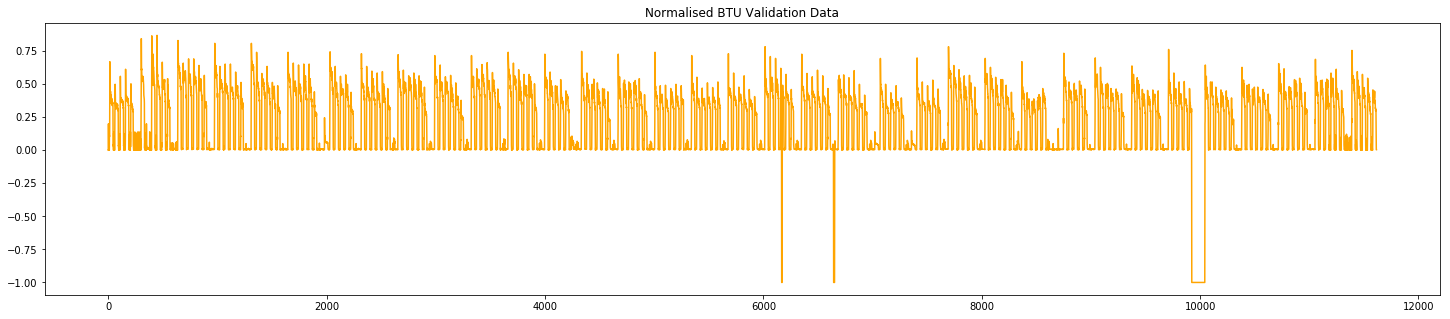

In [18]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_val_data.shape[0]), as5_val_data[:, 1], color='orange')
plt.title('Normalised BTU Validation Data')

## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [19]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## 4x128 GRU, 2x32 Dense Layer Model (no shuffling of samples)

In [20]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [21]:
model = Sequential()
model.add(layers.CuDNNGRU(128, return_sequences=True, input_shape=(None, as5_train_data.shape[-1])))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [22]:
gen_train = mu.DataGenerator(as5_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_data,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data) - 1,
                           batch_size=batch_size, step=step)

print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 88


In [23]:
gen_train.__getitem__(142)[0].shape

(128, 240, 2)

In [24]:
gen_train.__getitem__(143)[0].shape

(16, 240, 2)

In [33]:
# # Temporary - to remove after training is completed
# # Load previous history
# with open(os.path.join('models', 'base-imp-4x128gru-2x32dense-histories-epch300.pkl'), 'rb') as infile:
#     histories = pickle.load(infile)
# Load previous model
# from keras.models import load_model
# model = load_model(os.path.join('models', 'base-imp-4x128gru-epch300.h5'))
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [25]:
callbacks_list = [
    ModelCheckpoint(
        # filepath='base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7.{epoch:02d}-{val_loss:.2f}.h5',
        filepath='base-imp-4x128gru-2x32dense.best.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [26]:
# No shuffling of the samples in each mini-batch
t1 = datetime.datetime.now()
print('Training start time = {}'.format(t1))
history = model.fit_generator(generator=gen_train, epochs=300,
                              callbacks=callbacks_list,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=False, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-08 15:31:21.466179

Training Duration = 1:01:00.554349


In [27]:
# histories = [] # for first training session
histories.append(history.history)

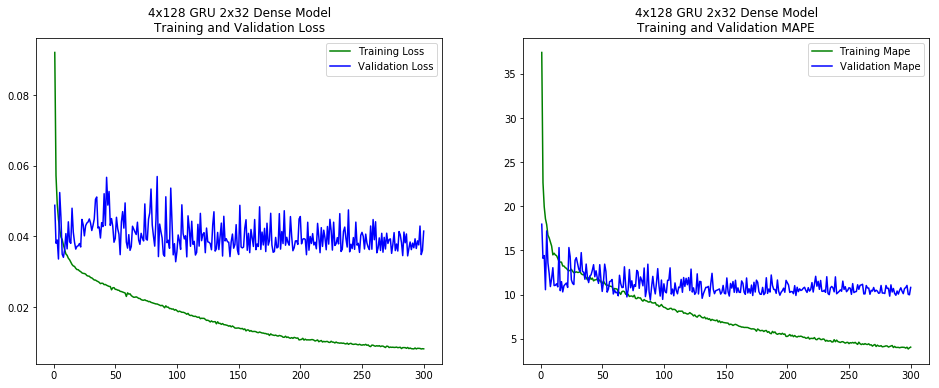

In [28]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [29]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.008170
Validation min loss = 0.032852
Validation min epoch = 98


In [30]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_split_df['PWM_30min_avg'].max() - as5_train_split_df['PWM_30min_avg'].min())),
                                               (min(val_loss[-10:]) * (as5_train_split_df['PWM_30min_avg'].max() - as5_train_split_df['PWM_30min_avg'].min()))))

Train MAE = 0.560686
Validation MAE = 2.393351


In [33]:
# Load best model
best_model = load_model(os.path.join('models', 'base-imp-4x128gru-2x32dense.best.h5'))
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [34]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(18320, 1)

In [46]:
gen_val_pred = mu.DataGenerator(as5_val_data,
                                lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data) - 1,
                                batch_size=batch_size, step=step)
as5_val_preds = best_model.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)
as5_val_preds.shape

(11236, 1)

In [35]:
my_pipeline.steps

[('selector',
  DataFrameSelector(attribute_names=['PWM_30min_avg', 'BTU_30min_avg'])),
 ('minmax_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('na_transform', Nan_to_Num_Transformer(num=-1))]

In [36]:
# pt = PowerTransformer(copy=True, method='yeo-johnson', standardize=False)
# mm = MinMaxScaler(copy=True, feature_range=(0, 1))
as5_train_preds1 = np.concatenate([as5_train_preds, np.zeros((as5_train_preds.shape[0], 1))], axis=1)
as5_train_preds1.shape

(18320, 2)

In [37]:
as5_train_preds1[:5]

array([[0.4919998 , 0.        ],
       [0.5356276 , 0.        ],
       [0.52592474, 0.        ],
       [0.49955395, 0.        ],
       [0.4875688 , 0.        ]])

In [38]:
# as5_train_preds1 = my_pipeline.steps[1][1].inverse_transform(my_pipeline.steps[2][1].inverse_transform(as5_train_preds))
as5_train_preds1 = my_pipeline.inverse_transform(as5_train_preds1)
as5_train_preds1

array([[ 4.75159466e+01, -1.73472348e-18],
       [ 5.05101224e+01, -1.73472348e-18],
       [ 4.98442151e+01, -1.73472348e-18],
       ...,
       [ 2.48945502e+01, -1.73472348e-18],
       [ 2.57370230e+01, -1.73472348e-18],
       [ 2.60017679e+01, -1.73472348e-18]])

In [39]:
as5_train_preds1[:, 0]

array([47.51594662, 50.51012243, 49.84421506, ..., 24.89455017,
       25.73702299, 26.00176787])

In [51]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds1[j, 0]
        j += 1
as5_train_preds_withnan.shape

(20000, 1)

In [41]:
as5_train_df['PWM_30min_avg'].values.shape

(31616,)

In [48]:
as5_val_preds1 = np.concatenate([as5_val_preds, np.zeros((as5_val_preds.shape[0], 1))], axis=1)
as5_val_preds1 = my_pipeline.inverse_transform(as5_val_preds1)
as5_val_preds_withnan = np.full((as5_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_val_data)):
    if as5_val_data[i, 0] > -1:
        as5_val_preds_withnan[i] = as5_val_preds1[j, 0]
        j += 1
as5_val_preds_withnan.shape

(11616, 1)

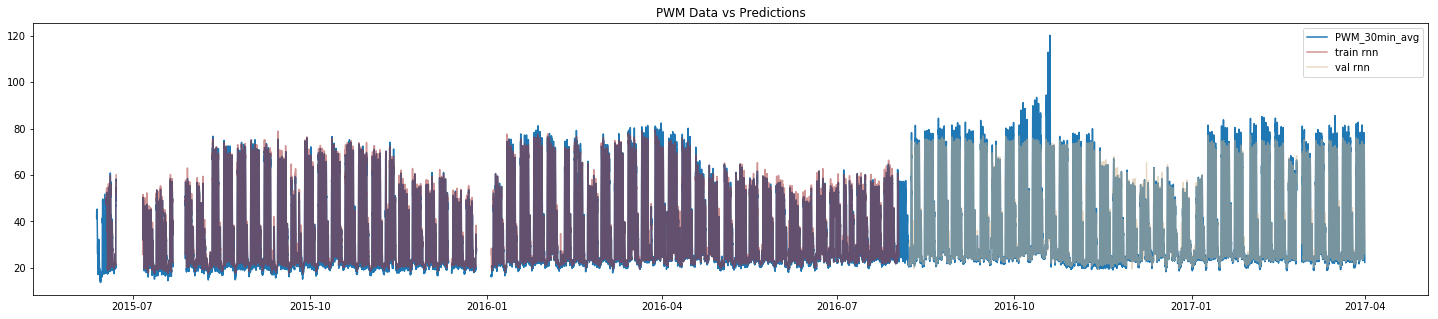

In [53]:
# plt.figure(figsize=(25, 5))
# plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
# plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
# plt.title('PWM Data vs Predictions')
# plt.legend()

plt.figure(figsize=(25, 5))
plt.plot(as5_train_df['PWM_30min_avg'])
plt.plot(as5_train_df.index[:20000], as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.plot(as5_train_df.index[20000:], as5_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

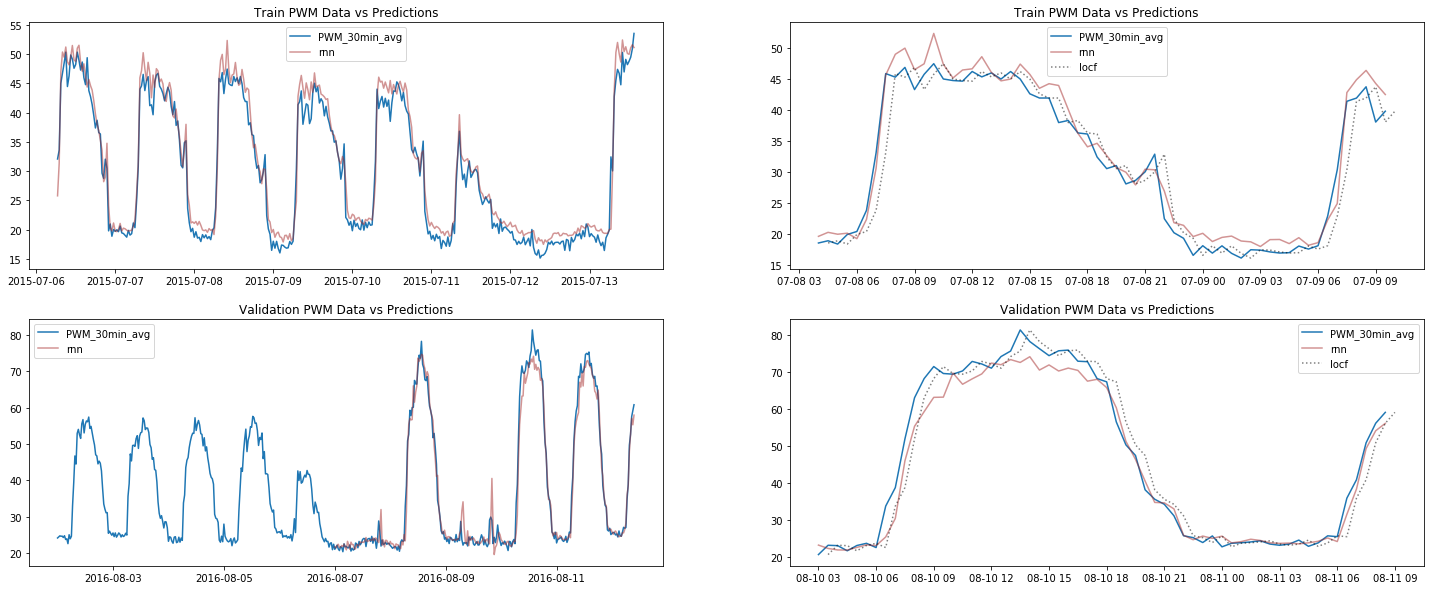

In [57]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(as5_train_df.iloc[1000:1500, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[1000:1500], as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(as5_train_df.iloc[1240:1300, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[1240:1300], as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(as5_train_df.index[1241:1301], as5_train_df.iloc[1240:1300, as5_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(as5_train_df.iloc[20000:20500, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[20000:20500], as5_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(as5_train_df.iloc[20390:20450, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[20390:20450], as5_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(as5_train_df.index[20391:20451], as5_train_df.iloc[20390:20450, as5_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [31]:
model.save('base-imp-4x128gru.h5')

In [32]:
with open('base-imp-4x128gru-2x32dense-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## 4x128 GRU, 2x32 Dense Layer Stateful Model

In [20]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [21]:
model = Sequential()
# model.add(layers.CuDNNGRU(128, return_sequences=True, batch_input_shape=(batch_size, lookback, as5_train_data.shape[-1]), stateful=True))
model.add(layers.CuDNNGRU(128, return_sequences=True, batch_input_shape=(lookback, lookback, as5_train_data.shape[-1]), stateful=True))
model.add(layers.CuDNNGRU(128, return_sequences=True, stateful=True))
model.add(layers.CuDNNGRU(128, return_sequences=True, stateful=True))
model.add(layers.CuDNNGRU(128, stateful=True))
model.add(layers.Dense(32, activation='relu'))  # use relu to avoid vanishing gradients
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))  # cannot use sigmoid to get an easy to compute loss gradient (cross-entropy with sigmoid has easy derivative) because output can be > 1
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (240, 240, 128)           50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (240, 240, 128)           99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (240, 240, 128)           99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (240, 128)                99072     
_________________________________________________________________
dense_1 (Dense)              (240, 32)                 4128      
_________________________________________________________________
dense_2 (Dense)              (240, 32)                 1056      
_________________________________________________________________
dense_3 (Dense)              (240, 1)                  33        
Total para

In [22]:
# Using lookback as the batch size.
gen_train = mu.DataGeneratorForStateFulRNN(as5_train_data,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                             batch_size=lookback, step=step)
# gen_val = mu.DataGeneratorForStateFulRNN(as5_val_data,
#                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data) - 1,
#                            batch_size=lookback, step=step)

# print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))
print('train batches = %d' % gen_train.__len__())

train batches = 74


In [ ]:
histories = []

In [23]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base1-stateful-4x128gru-2x32dense-histories-epch300.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base1-stateful-4x128gru-2x32dense-epch300.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (240, 240, 128)           50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (240, 240, 128)           99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (240, 240, 128)           99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (240, 128)                99072     
_________________________________________________________________
dense_1 (Dense)              (240, 32)                 4128      
_________________________________________________________________
dense_2 (Dense)              (240, 32)                 1056      
_________________________________________________________________
dense_3 (Dense)              (240, 1)                  33        
Total para

#### Check the generator

In [23]:
for i in range(10):
    print(i, gen_train.dict_seq_from_last_batch[i])

0 True
1 False
2 True
3 True
4 False
5 True
6 True
7 True
8 True
9 True


In [24]:
# Checking the batch 0. 240 to 479 is 240 samples.
gen_train.dict_batch_idx[0][-10:]

[470, 471, 472, 473, 474, 475, 476, 477, 478, 479]

In [25]:
# Batch 1 is not contiguous with batch 0.
gen_train.dict_batch_idx[1][:10]

[1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158]

In [26]:
# Batch 1 is contiguous with batch 2.
gen_train.dict_batch_idx[1][-10:]

[1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388]

In [27]:
gen_train.dict_batch_idx[2][:10]

[1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398]

In [28]:
for i in range(40, 45):
    print(i, gen_train.dict_seq_from_last_batch[i])

40 True
41 True
42 False
43 False
44 True


In [29]:
print(gen_train.dict_batch_idx[41][-10:], ' ', gen_train.dict_batch_idx[42][:10])

[11990, 11991, 11992, 11993, 11994, 11995, 11996, 11997, 11998, 11999]   [12011, 12012, 12013, 12014, 12015, 12016, 12017, 12018, 12019, 12020]


In [30]:
# Batch 42 is not contiguous with batch 41.
print(gen_train.dict_batch_idx[42][-10:], ' ', gen_train.dict_batch_idx[43][:10])

[12241, 12242, 12243, 12244, 12245, 12246, 12247, 12248, 12249, 12250]   [12284, 12285, 12286, 12287, 12288, 12289, 12290, 12291, 12292, 12293]


In [31]:
# Batch 43 is not contiguous with batch 42.
print(gen_train.dict_batch_idx[43][-10:], ' ', gen_train.dict_batch_idx[44][:10])

[12514, 12515, 12516, 12517, 12518, 12519, 12520, 12521, 12522, 12523]   [12524, 12525, 12526, 12527, 12528, 12529, 12530, 12531, 12532, 12533]


In [32]:
# Check last batch. Remaining sample from 19868 to 19999 is less than 240.
print(gen_train.dict_batch_idx[73][-10:], '\n', as5_train_data.shape)

[19858, 19859, 19860, 19861, 19862, 19863, 19864, 19865, 19866, 19867] 
 (20000, 2)


#### Custom validation score callback

In [33]:
val_cb = mu.ValidationScoreCb(as5_val_data, lookback, delay, min_index=0, max_index=len(as5_val_data) - 1, batch_size=lookback, step=step, verbose=1, save_model = True)

In [34]:
len(as5_val_data)

11616

In [35]:
total = 0
for i in val_cb.batch_list:
    print(len(i[0]))
    total += len(i[0])
print(total)

5520
240
240
3120
1440
10560


In [36]:
np.where(as5_val_data[:, 0] == -1)

(array([ 5807,  5808,  5809,  5810,  6167,  6168,  6169,  6170,  6171,
         6172,  6643,  6644,  6645,  6646,  6647,  6648,  6649,  6650,
         6651,  9923,  9924,  9925,  9926,  9927,  9928,  9929,  9930,
         9931,  9932,  9933,  9934,  9935,  9936,  9937,  9938,  9939,
         9940,  9941,  9942,  9943,  9944,  9945,  9946,  9947,  9948,
         9949,  9950,  9951,  9952,  9953,  9954,  9955,  9956,  9957,
         9958,  9959,  9960,  9961,  9962,  9963,  9964,  9965,  9966,
         9967,  9968,  9969,  9970,  9971,  9972,  9973,  9974,  9975,
         9976,  9977,  9978,  9979,  9980,  9981,  9982,  9983,  9984,
         9985,  9986,  9987,  9988,  9989,  9990,  9991,  9992,  9993,
         9994,  9995,  9996,  9997,  9998,  9999, 10000, 10001, 10002,
        10003, 10004, 10005, 10006, 10007, 10008, 10009, 10010, 10011,
        10012, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 10020,
        10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029,
      

For the first batch, 5807 - 240 / 240 = 23.2 or 23 mini-batches which is 5520 samples. For the 2nd batch, 6167 - 5811 / 240 = 1.5 or 1 mini-batch which is 240 samples.

In [37]:
# batch_list is a list of [samples, targets]
# batch 1 has 240 samples
val_cb.batch_list[1][0].shape

(240, 240, 2)

In [38]:
val_cb.batch_list[1][0][0, :5, :]

array([[0.11598426, 0.00734105],
       [0.1215212 , 0.00696777],
       [0.09893633, 0.0070922 ],
       [0.09514789, 0.00696777],
       [0.11248725, 0.00734105]])

In [39]:
callbacks_list = [
    # Can save best model only if val_loss available - fix by adding val_loss into log param?
    # ModelCheckpoint(
    #     # filepath='base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7.{epoch:02d}-{val_loss:.2f}.h5',
    #     filepath='base-yj-4x128gru-2x32dense.best.h5',
    #     monitor='val_loss',
    #     save_best_only=True
    # ),
    TensorBoard(
        log_dir='tsb_log'
    ),
    mu.ResetStateCb(gen_train),
    val_cb
]

#### Train the model

In [40]:
t1 = datetime.datetime.now()
print('Training start time = {}'.format(t1))
history = model.fit_generator(generator=gen_train, epochs=300, callbacks=callbacks_list,
                              workers=3, use_multiprocessing=False, shuffle=False, verbose=0)  # shuffle = False!!
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-02-18 21:43:55.303389

Training Duration = 0:50:32.037094


In [41]:
val_cb.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_percentage_error'])

In [42]:
histories.append({**history.history, **val_cb.history})

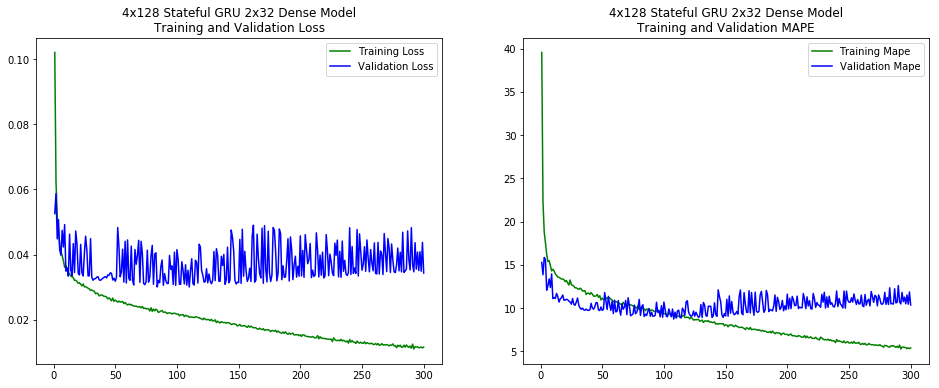

In [24]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 Stateful GRU 2x32 Dense Model\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 Stateful GRU 2x32 Dense Model\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [25]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.011009
Validation min loss = 0.030036
Validation min epoch = 109


In [26]:
print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_split_df['PWM_30min_avg'].max() - as5_train_split_df['PWM_30min_avg'].min())),
                                               (min(val_loss) * (as5_train_split_df['PWM_30min_avg'].max() - as5_train_split_df['PWM_30min_avg'].min()))))

Train MAE = 0.755541
Validation MAE = 2.061397


In [47]:
# Load best model
best_model = Sequential()
# model.add(layers.CuDNNGRU(128, return_sequences=True, batch_input_shape=(batch_size, lookback, as5_train_data.shape[-1]), stateful=True))
best_model.add(layers.CuDNNGRU(128, return_sequences=True, batch_input_shape=(lookback, lookback, as5_train_data.shape[-1]), stateful=True))
best_model.add(layers.CuDNNGRU(128, return_sequences=True, stateful=True))
best_model.add(layers.CuDNNGRU(128, return_sequences=True, stateful=True))
best_model.add(layers.CuDNNGRU(128, stateful=True))
best_model.add(layers.Dense(32, activation='relu'))  # use relu to avoid vanishing gradients
best_model.add(layers.Dense(32, activation='relu'))
best_model.add(layers.Dense(1))  # cannot use sigmoid to get an easy to compute loss gradient (cross-entropy with sigmoid has easy derivative) because output can be > 1


best_model.load_weights(os.path.join('models', 'base1-stateful-4x128gru-2x32dense', 'weights-epoch 100-val_loss0.04.h5'))

best_model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_9 (CuDNNGRU)       (240, 240, 128)           50688     
_________________________________________________________________
cu_dnngru_10 (CuDNNGRU)      (240, 240, 128)           99072     
_________________________________________________________________
cu_dnngru_11 (CuDNNGRU)      (240, 240, 128)           99072     
_________________________________________________________________
cu_dnngru_12 (CuDNNGRU)      (240, 128)                99072     
_________________________________________________________________
dense_7 (Dense)              (240, 32)                 4128      
_________________________________________________________________
dense_8 (Dense)              (240, 32)                 1056      
_________________________________________________________________
dense_9 (Dense)              (240, 1)                  33        
Total para

In [48]:
# gen_pred = mu.DataGenerator(
#     as5_train_data,
#     lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
#     batch_size=lookback, step=step)
# as5_train_preds = best_model.predict_generator(gen_train_pred, workers=3, use_multiprocessing=False)

batch_list, rows_list = mu.get_contiguous_batches(as5_train_data, lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1, batch_size=lookback, step=step)
as5_train_preds_list = []
for a_batch in batch_list:
    as5_train_preds_list.append(best_model.predict(a_batch[0], batch_size=lookback))
as5_train_preds = np.concatenate(as5_train_preds_list)
as5_train_preds.shape
# There are 74 training mini-batches which is 17760 samples

(17760, 1)

In [49]:
as5_train_preds1 = np.concatenate([as5_train_preds, np.zeros((as5_train_preds.shape[0], 1))], axis=1)
as5_train_preds1.shape

(17760, 2)

In [50]:
as5_train_preds1 = my_pipeline.inverse_transform(as5_train_preds1)
as5_train_preds1

array([[ 4.93801944e+01, -1.73472348e-18],
       [ 4.97137432e+01, -1.73472348e-18],
       [ 4.65673864e+01, -1.73472348e-18],
       ...,
       [ 2.33497968e+01, -1.73472348e-18],
       [ 2.34543154e+01, -1.73472348e-18],
       [ 2.40040376e+01, -1.73472348e-18]])

In [51]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
all_rows = np.concatenate(rows_list)
for i in range(lookback, len(as5_train_data)):
    # if as5_train_data[i, 0] > -1:
    if i in all_rows:
        as5_train_preds_withnan[i] = as5_train_preds1[j, 0]
        j += 1
as5_train_preds_withnan.shape

(20000, 1)

In [52]:
# gen_val_pred = mu.DataGenerator(as5_val_data,
#                                 lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data) - 1,
#                                 batch_size=batch_size, step=step)
# as5_val_preds = best_model.predict_generator(gen_val_pred, workers=3, use_multiprocessing=False)

batch_list, rows_list = mu.get_contiguous_batches(as5_val_data, lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_data) - 1, batch_size=lookback, step=step)
as5_val_preds_list = []
for a_batch in batch_list:
    as5_val_preds_list.append(best_model.predict(a_batch[0], batch_size=lookback))
as5_val_preds = np.concatenate(as5_val_preds_list)
as5_val_preds.shape

(10560, 1)

In [53]:
as5_val_preds1 = np.concatenate([as5_val_preds, np.zeros((as5_val_preds.shape[0], 1))], axis=1)
as5_val_preds1 = my_pipeline.inverse_transform(as5_val_preds1)
as5_val_preds_withnan = np.full((as5_val_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_val_data)):
    # if as5_val_data[i, 0] > -1:
    if i in all_rows:
        as5_val_preds_withnan[i] = as5_val_preds1[j, 0]
        j += 1
as5_val_preds_withnan.shape

(11616, 1)

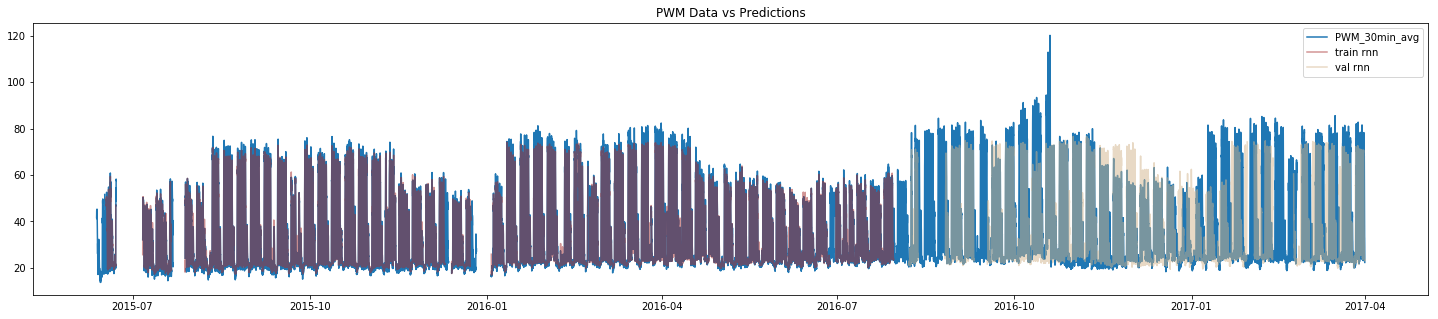

In [54]:
plt.figure(figsize=(25, 5))
plt.plot(as5_train_df['PWM_30min_avg'])
plt.plot(as5_train_df.index[:20000], as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.plot(as5_train_df.index[20000:], as5_val_preds_withnan.flatten(), color='tan', alpha=.5, label='val rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

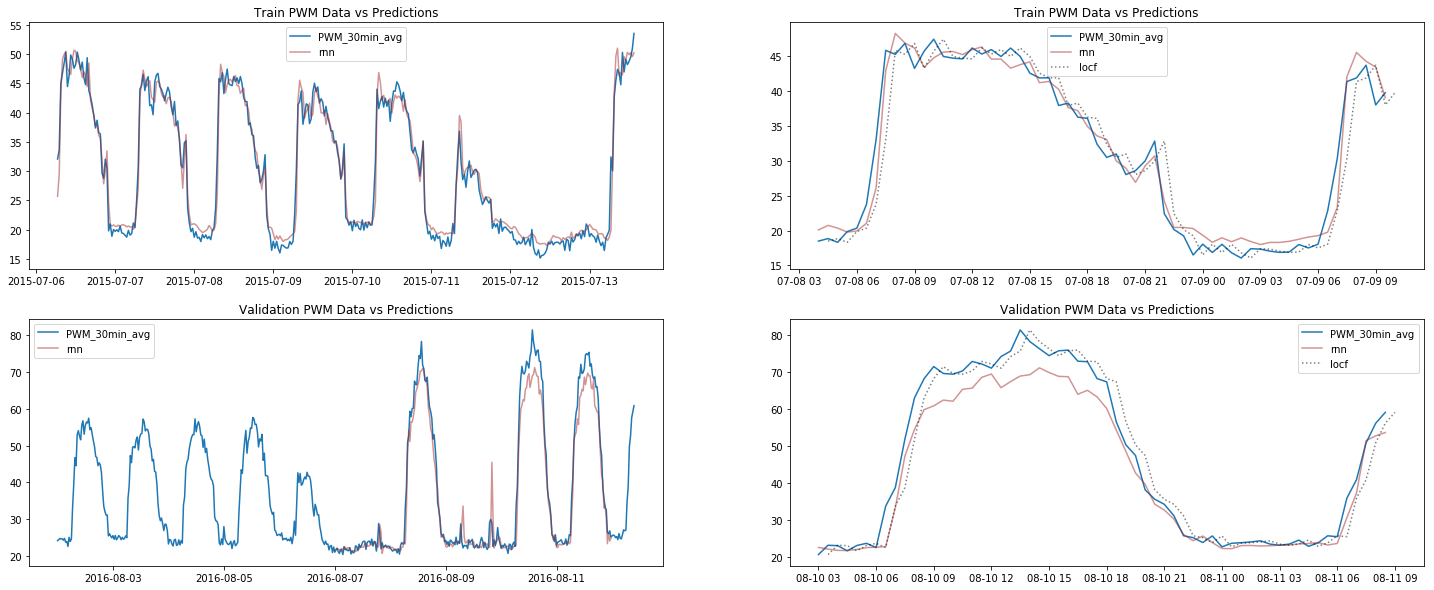

In [55]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(as5_train_df.iloc[1000:1500, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[1000:1500], as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(as5_train_df.iloc[1240:1300, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[1240:1300], as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(as5_train_df.index[1241:1301], as5_train_df.iloc[1240:1300, as5_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(as5_train_df.iloc[20000:20500, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[20000:20500], as5_val_preds_withnan[:500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(as5_train_df.iloc[20390:20450, as5_train_df.columns.get_loc('PWM_30min_avg')], label='PWM_30min_avg')
plt.plot(as5_train_df.index[20390:20450], as5_val_preds_withnan[390:450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(as5_train_df.index[20391:20451], as5_train_df.iloc[20390:20450, as5_train_df.columns.get_loc('PWM_30min_avg')].values, color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [56]:
model.save('base1-stateful-4x128gru-2x32dense.h5')

In [57]:
with open('base1-stateful-4x128gru-2x32dense-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)